In [1]:
# @title Download data

import os
os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""
!kaggle competitions download -c child-mind-institute-detect-sleep-states
!unzip child-mind-institute-detect-sleep-states.zip -d child-mind-institute-detect-sleep-states

100% 808M/811M [00:09<00:00, 50.7MB/s]
100% 811M/811M [00:09<00:00, 92.3MB/s]
Archive:  child-mind-institute-detect-sleep-states.zip
  inflating: child-mind-institute-detect-sleep-states/sample_submission.csv  
  inflating: child-mind-institute-detect-sleep-states/test_series.parquet  
  inflating: child-mind-institute-detect-sleep-states/train_events.csv  
  inflating: child-mind-institute-detect-sleep-states/train_series.parquet  


In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import numpy as np
import pandas as pd

In [3]:
# @title Load single sample
input_file = '/content/child-mind-institute-detect-sleep-states/train_series.parquet'
label_file = '/content/child-mind-institute-detect-sleep-states/train_events.csv'
sample_ids = (
                    pl.scan_parquet(input_file)
                    .select('series_id')
                ).fetch(5)

sample_id = sample_ids['series_id'][0]

# get the mean and std
statistics = (
            pl.scan_parquet(input_file)
            .filter(
                pl.col('series_id') == sample_id
            )
            .select(
                mean = pl.col('anglez').mean(),
                std = pl.col('anglez').std()
            )
        ).collect().to_pandas()

mean = statistics['mean'].iloc[0]
std = statistics['std'].iloc[0]
print(f"{mean=} | {std=}")

sample = (
            pl.scan_parquet(input_file)
            .filter(
                pl.col('series_id') == sample_id
            )
            .with_columns(
                (
                    (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
                    (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.date().alias("date")),
                    (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.time().alias("time")),
                    ((pl.col('anglez') - mean) / std) # standardize the data
                )
            )
        ).collect().to_pandas()

train_events = (pl.scan_csv(label_file)
                .filter(
                    pl.col('series_id') == sample_id
                )
                .with_columns(
                    (
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.date().alias("date")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.time().alias("time")),
                    )
                ).collect().to_pandas()
               )

sample = sample.set_index('timestamp')
print(f"{sample.anglez.min()=} | {sample.anglez.max()=}")
sample.head()

mean=-13.668002 | std=37.609493
sample.anglez.min()=-2.0183415 | sample.anglez.max()=2.7310896


,series_id,step,anglez,enmo,date,time
timestamp,,,,,,
2018-08-14 15:30:00,038441c925bb,0,0.433526,0.0217,2018-08-14,15:30:00
2018-08-14 15:30:05,038441c925bb,1,0.433529,0.0215,2018-08-14,15:30:05
2018-08-14 15:30:10,038441c925bb,2,0.433534,0.0216,2018-08-14,15:30:10
2018-08-14 15:30:15,038441c925bb,3,0.433529,0.0213,2018-08-14,15:30:15
2018-08-14 15:30:20,038441c925bb,4,0.433529,0.0215,2018-08-14,15:30:20


In [4]:
train_events.head()

,series_id,night,event,step,timestamp,date,time
0,038441c925bb,1,onset,4992.0,2018-08-14 22:26:00,2018-08-14,22:26:00
1,038441c925bb,1,wakeup,10932.0,2018-08-15 06:41:00,2018-08-15,06:41:00
2,038441c925bb,2,onset,20244.0,2018-08-15 19:37:00,2018-08-15,19:37:00
3,038441c925bb,2,wakeup,27492.0,2018-08-16 05:41:00,2018-08-16,05:41:00
4,038441c925bb,3,onset,39996.0,2018-08-16 23:03:00,2018-08-16,23:03:00


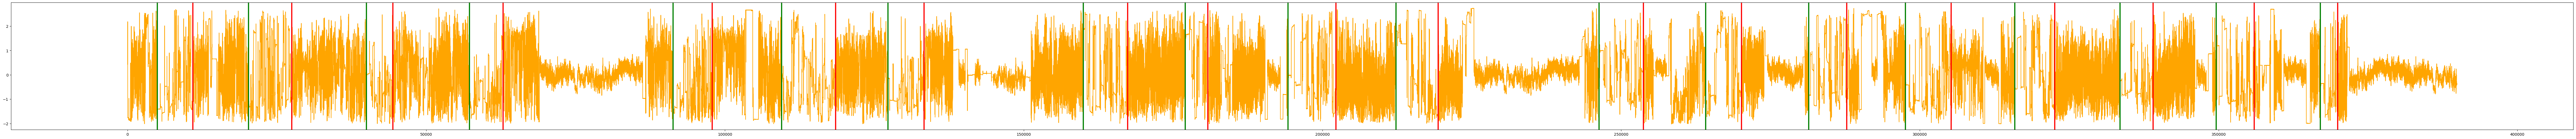

In [5]:
# @title Visualize the data

def plot_series(data, value_column='anglez', labels=None, predictions=None, show_quantile=False, snippet_range=None, figsize=(120,6)):
    '''
    Input
        data - dataframe with columns: anglez
        labels - dataframe with columns: event and step
        predictions - dataframe with columns: event and step
    '''
    start_idx, end_idx = snippet_range if snippet_range is not None else (0,data.shape[0])

    plt.figure(figsize=figsize)

    plt.plot(list(range(data.shape[0]))[start_idx:end_idx], data[value_column].to_list()[start_idx:end_idx], color='orange')

    if labels is not None:
        for event, step in list(zip(labels.event.to_list(), labels.step.to_list())):
            if step < start_idx or step > end_idx:
                continue

            if event == 'onset':
                plt.axvline(x=step, color='green', linewidth=3)
            elif event == 'wakeup':
                plt.axvline(x=step, color='red', linewidth=3)

    if predictions is not None:
        max_value = data[value_column][start_idx:end_idx].max()
        start, end = None, None

        for event, step in list(zip(predictions.event.to_list(), predictions.step.to_list())):
            if step < start_idx or step > end_idx:
                continue

            if event == 'onset':
                start = step
            elif event == 'wakeup':
                end = step
                if start is None:
                    start = start_idx
                duration = list(range(start, end))
                plt.scatter(duration, [max_value]*len(duration), color='blue', s=1)

    if show_quantile:
        plt.scatter(list(range(data.shape[0]))[start_idx:end_idx], data['10th_percentile'].to_list()[start_idx:end_idx], color='gray', s=1)

    plt.show()

plot_series(data=sample,
            value_column='anglez',
            labels=train_events
            )

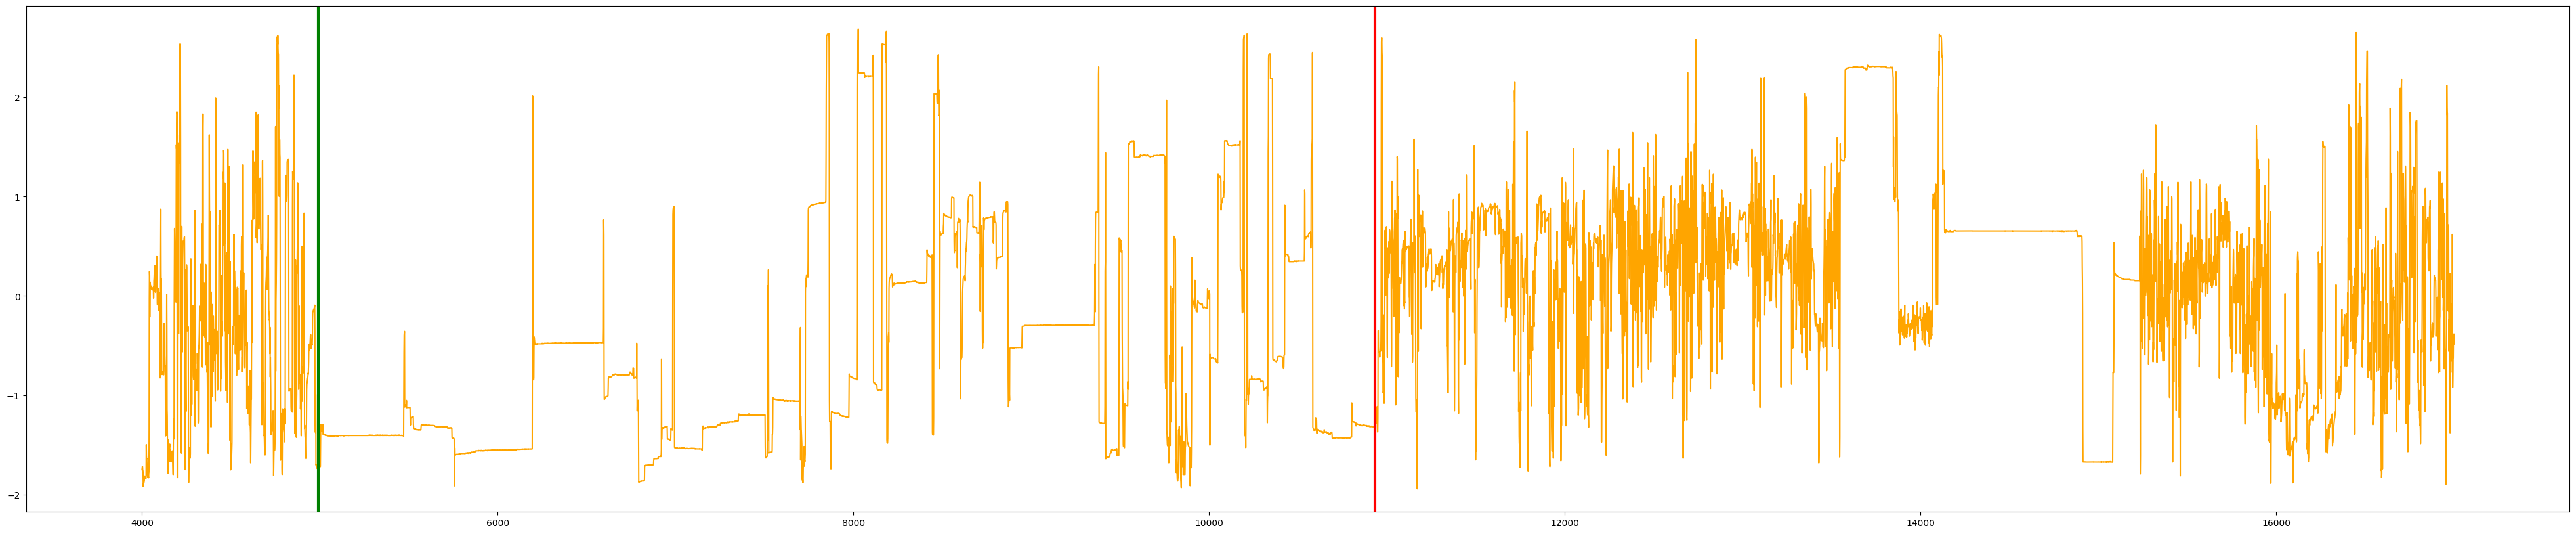

In [6]:
# @title HDCZA Step 1-3
plot_series(data=sample, value_column='anglez', labels=train_events,
            snippet_range=(4000,17000), figsize=(50,10)
            )

sample.step4.min()=0.0 | sample.step4.max()=3.997219443321228


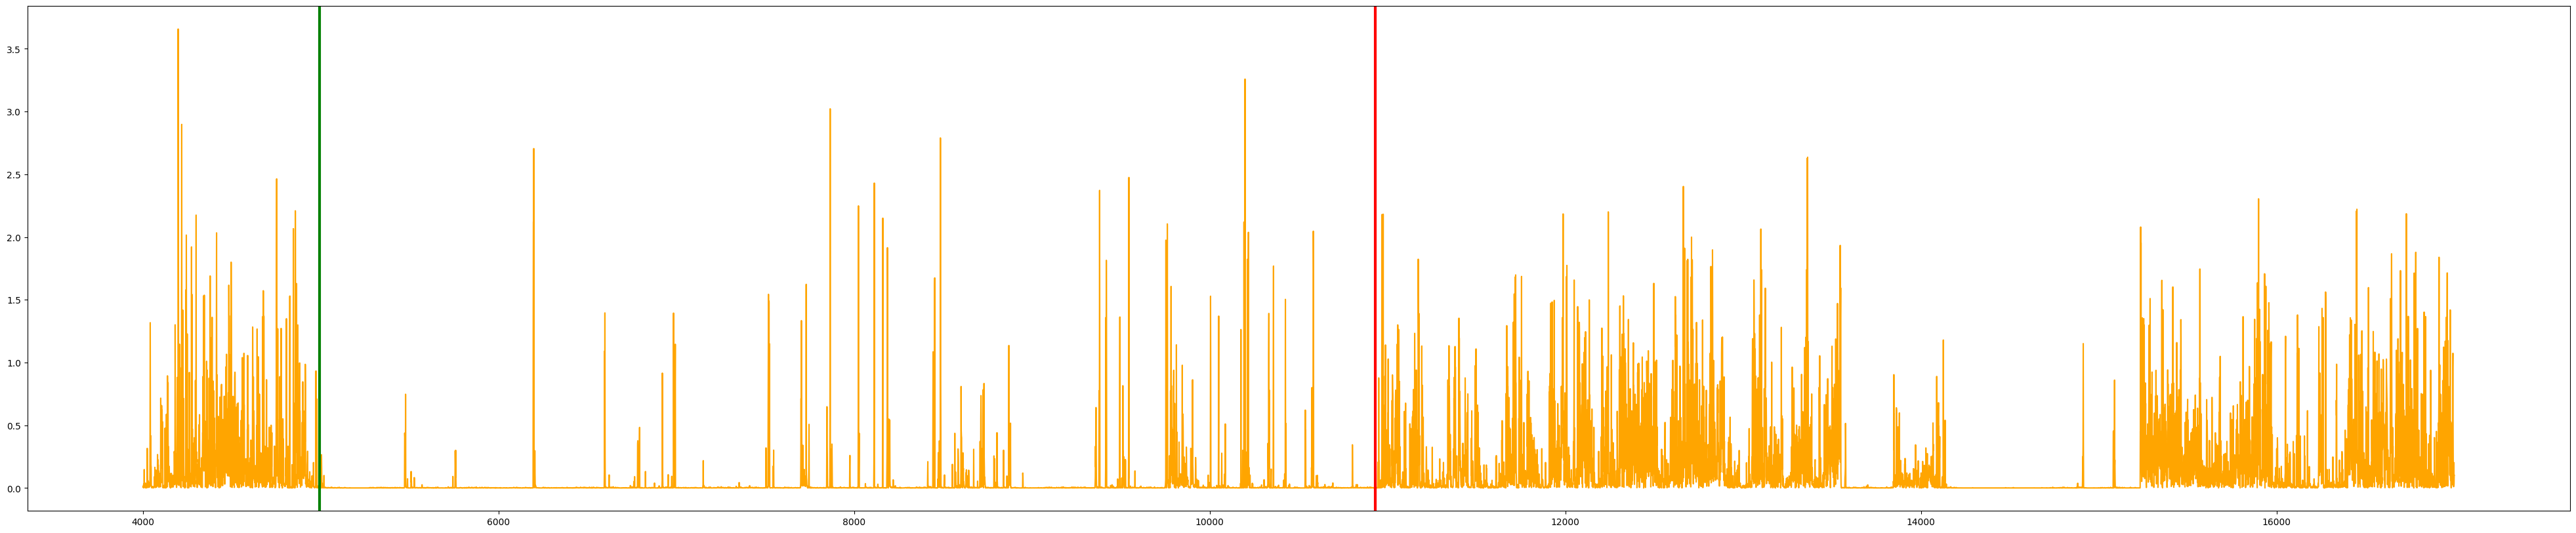

,series_id,step,anglez,enmo,date,time,step4
timestamp,,,,,,,
2018-08-14 15:30:00,038441c925bb,0,0.433526,0.0217,2018-08-14,15:30:00,NaN
2018-08-14 15:30:05,038441c925bb,1,0.433529,0.0215,2018-08-14,15:30:05,0.000003
2018-08-14 15:30:10,038441c925bb,2,0.433534,0.0216,2018-08-14,15:30:10,0.000005
2018-08-14 15:30:15,038441c925bb,3,0.433529,0.0213,2018-08-14,15:30:15,0.000005
2018-08-14 15:30:20,038441c925bb,4,0.433529,0.0215,2018-08-14,15:30:20,0.000000


In [7]:
# @title HDCZA Step 4

def angle_diff(x):
    a_diff  = (x.iloc[0] - x.iloc[1]) % 360
    if a_diff < 180:
        return a_diff
    else:
        return (360-a_diff)

sample['step4']  = sample.anglez.rolling(window=2, min_periods=2).apply(angle_diff)
print(f"{sample.step4.min()=} | {sample.step4.max()=}")

plot_series(data=sample, value_column='step4', labels=train_events,
            snippet_range=(4000,17000), figsize=(50,10))
sample.head()

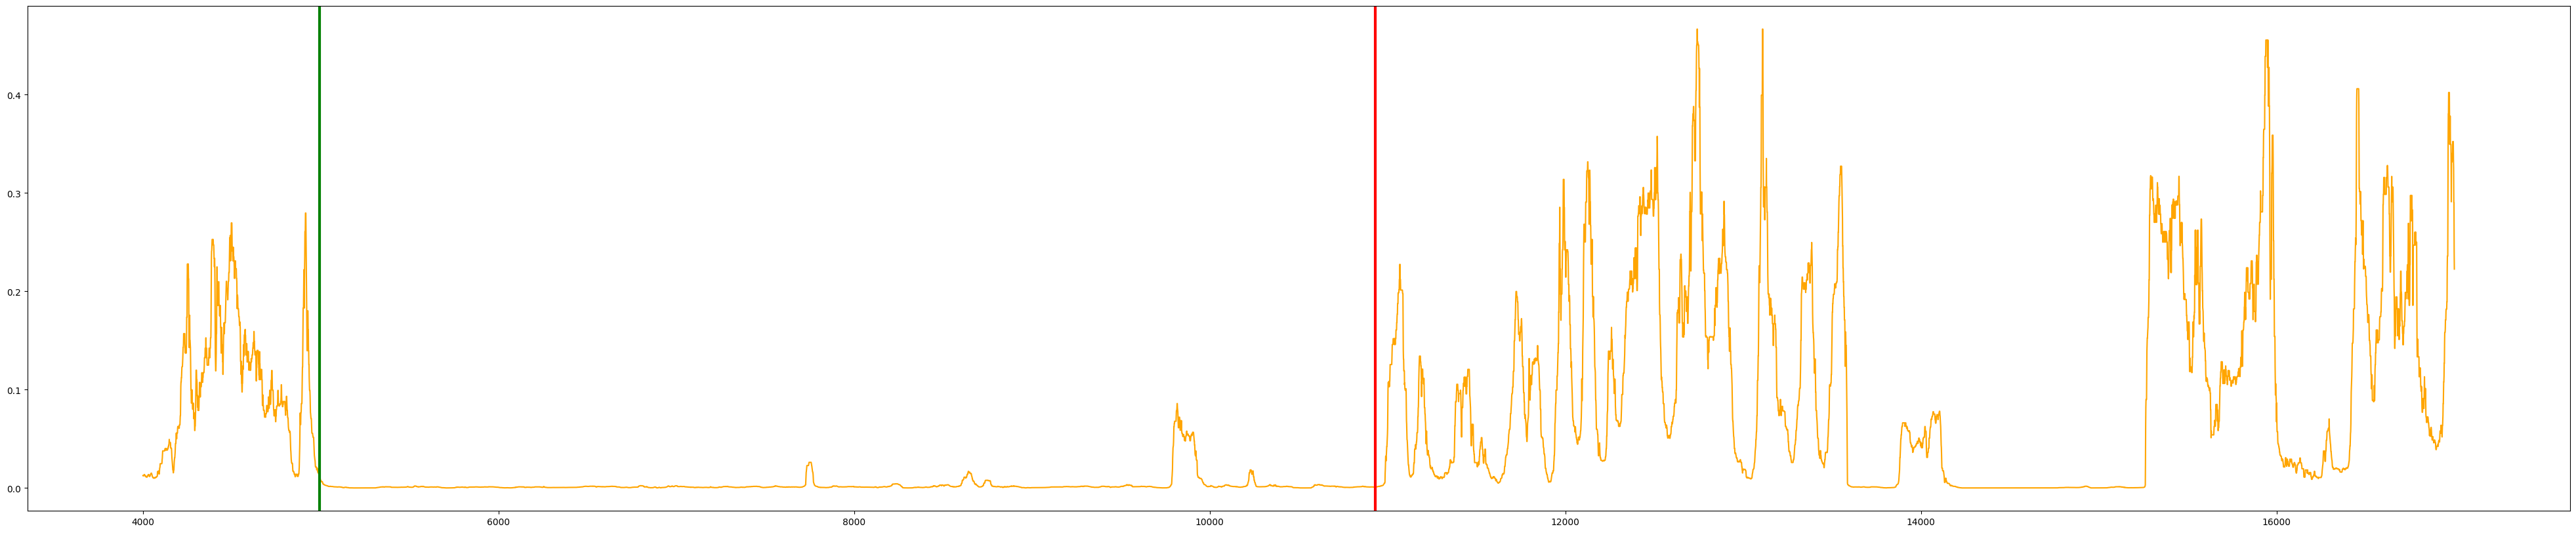

,series_id,step,anglez,enmo,date,time,step4,step5
timestamp,,,,,,,,
2018-08-14 15:30:00,038441c925bb,0,0.433526,0.0217,2018-08-14,15:30:00,NaN,NaN
2018-08-14 15:30:05,038441c925bb,1,0.433529,0.0215,2018-08-14,15:30:05,0.000003,NaN
2018-08-14 15:30:10,038441c925bb,2,0.433534,0.0216,2018-08-14,15:30:10,0.000005,NaN
2018-08-14 15:30:15,038441c925bb,3,0.433529,0.0213,2018-08-14,15:30:15,0.000005,NaN
2018-08-14 15:30:20,038441c925bb,4,0.433529,0.0215,2018-08-14,15:30:20,0.000000,NaN


In [8]:
# @title HDCZA Step 5
window_size = 60    # 5 min = 300 seconds = 60 steps (1 step = 5sec)
sample['step5'] = sample.step4.rolling(window=window_size).median()

plot_series(data=sample, value_column='step5', labels=train_events,
            snippet_range=(4000,17000), figsize=(50,10))

sample.head()

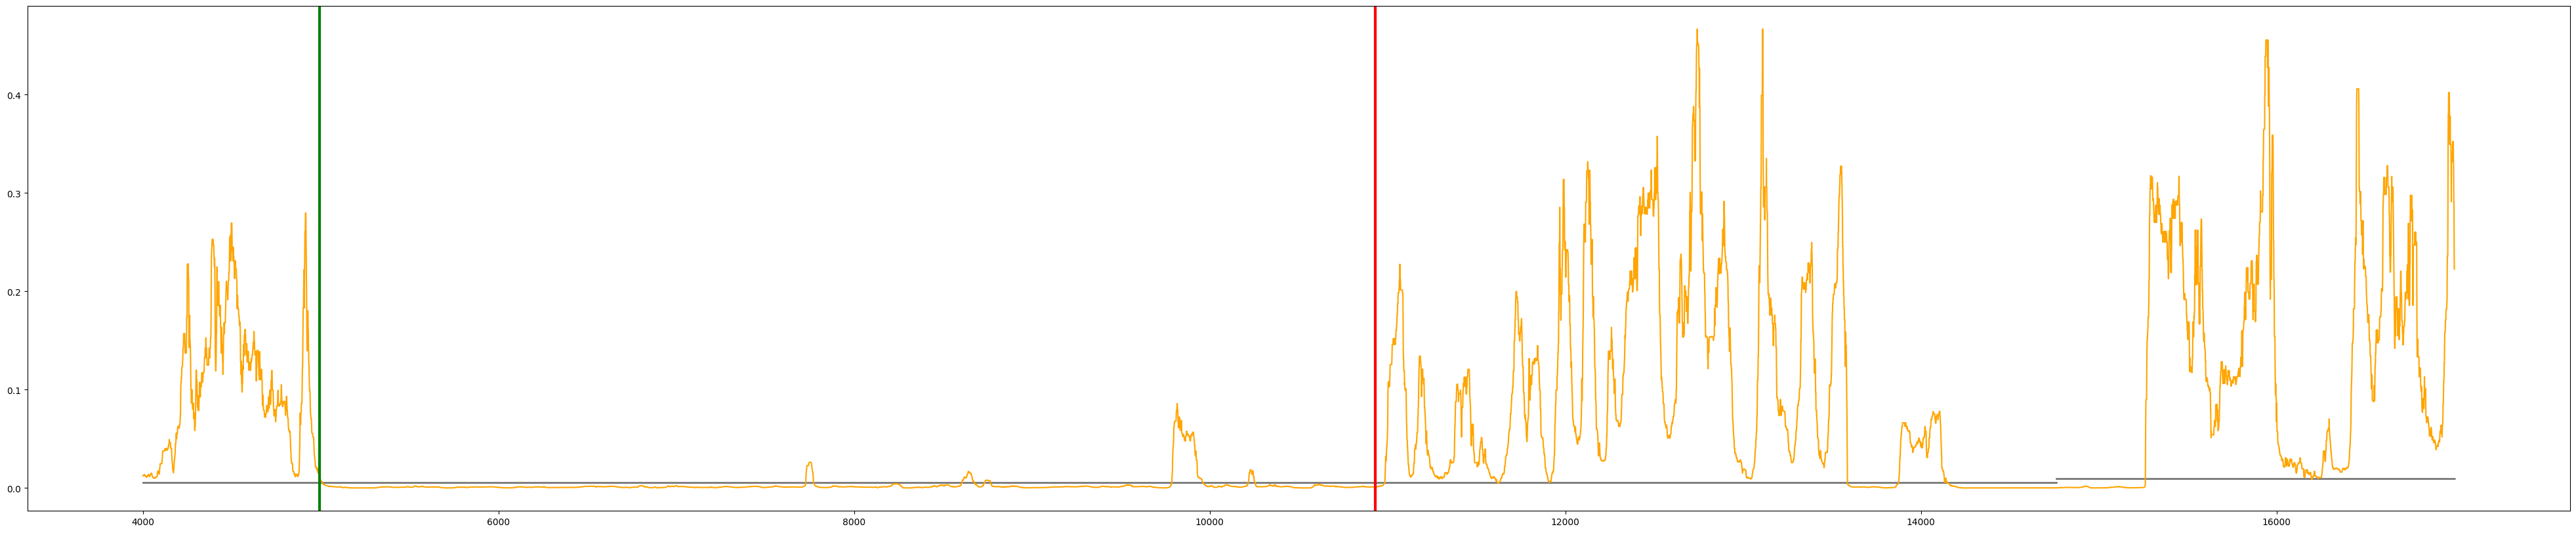

,series_id,step,anglez,enmo,date,time,step4,step5,10th_percentile,step6
timestamp,,,,,,,,,,
2018-08-14 15:35:00,038441c925bb,60,-1.763978,0.0138,2018-08-14,15:35:00,0.000027,0.000312,0.005242,True
2018-08-14 15:35:05,038441c925bb,61,-1.763744,0.0137,2018-08-14,15:35:05,0.000234,0.000312,0.005242,True
2018-08-14 15:35:10,038441c925bb,62,-1.763262,0.0135,2018-08-14,15:35:10,0.000481,0.000351,0.005242,True
2018-08-14 15:35:15,038441c925bb,63,-1.763494,0.0140,2018-08-14,15:35:15,0.000231,0.000351,0.005242,True
2018-08-14 15:35:20,038441c925bb,64,-1.763988,0.0132,2018-08-14,15:35:20,0.000494,0.000374,0.005242,True
...,...,...,...,...,...,...,...,...,...,...
2018-09-06 04:59:35,038441c925bb,389875,-0.364427,0.0110,2018-09-06,04:59:35,0.009942,0.009266,0.137798,True
2018-09-06 04:59:40,038441c925bb,389876,-0.367615,0.0110,2018-09-06,04:59:40,0.003188,0.007799,0.137798,True
2018-09-06 04:59:45,038441c925bb,389877,-0.368676,0.0111,2018-09-06,04:59:45,0.001061,0.006841,0.137798,True


In [9]:
# @title HDCZA Step 6
'''
Modifying the quantile and multiplier might be the hyperparameter we need to tune
'''

from pandas.api.indexers import BaseIndexer

class CustomIndexer(BaseIndexer):
    '''
    References:
        https://pandas.pydata.org/docs/user_guide/window.html#window-generic
    '''
    def get_window_bounds(self, num_values, min_periods, center, closed, step):
        start = list()
        end = list()

        period_start = min(self.timestamps[0].replace(hour=12, minute=0, second=0), # 12:00
                           self.timestamps[0] # 1st timestamp in data
                           )
        period_end = period_start + pd.DateOffset(1)

        period_start_idx = 0
        period_size = 0

        for i in range(num_values):
            if self.timestamps[i] > period_end:
                period_start = min(self.timestamps[i].replace(hour=12, minute=0, second=0), # 12:00
                                   self.timestamps[i] # current timestamp
                                   )
                period_end = period_start + pd.DateOffset(1)

                period_end_idx = i-1
                start.extend([period_start_idx]*period_size)
                end.extend([period_end_idx]*period_size)

                period_start_idx = i
                period_size = 1
            else:
                period_size += 1

        period_end_idx = i-1    # end of list is the end of the final group
        start.extend([period_start_idx]*period_size)
        end.extend([period_end_idx]*period_size)

        return np.array(start), np.array(end)

indexer = CustomIndexer(window_size=2, timestamps=sample.index)

sample['10th_percentile'] = sample.step5.rolling(indexer).quantile(.10) * 15
sample['step6'] = sample.step5 < sample['10th_percentile']

plot_series(data=sample, value_column='step5', labels=train_events, show_quantile=True,
            snippet_range=(4000,17000), figsize=(50,10)
            )

sample[sample.step6]

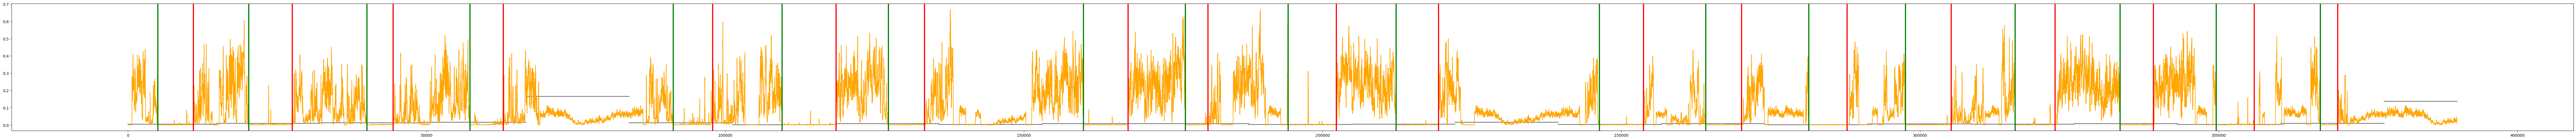

In [10]:
plot_series(data=sample, value_column='step5', labels=train_events, show_quantile=True,
            # snippet_range=(4000,17000), figsize=(50,10)
            )

sleep_periods.index.to_list()=[2, 6, 8, 12, 16, 22, 34, 38, 42, 56, 78, 122, 124, 138, 142, 244, 246, 248, 270, 272, 288, 298, 306, 352, 382, 392, 402, 430, 454, 456, 458, 466, 468, 470, 484, 488, 490, 492, 494, 496, 498, 502, 516, 532, 534, 536, 540, 544, 546, 552, 558, 562, 568, 572, 576, 586, 598, 602, 690, 694, 696, 698, 704, 708, 714, 732, 736, 738, 772, 774, 780, 782, 786, 816, 834, 836, 842, 844, 854, 856, 864, 866, 870, 872, 874, 878, 880, 886, 904, 910, 914, 916, 924, 926, 928, 930, 934, 946, 956]


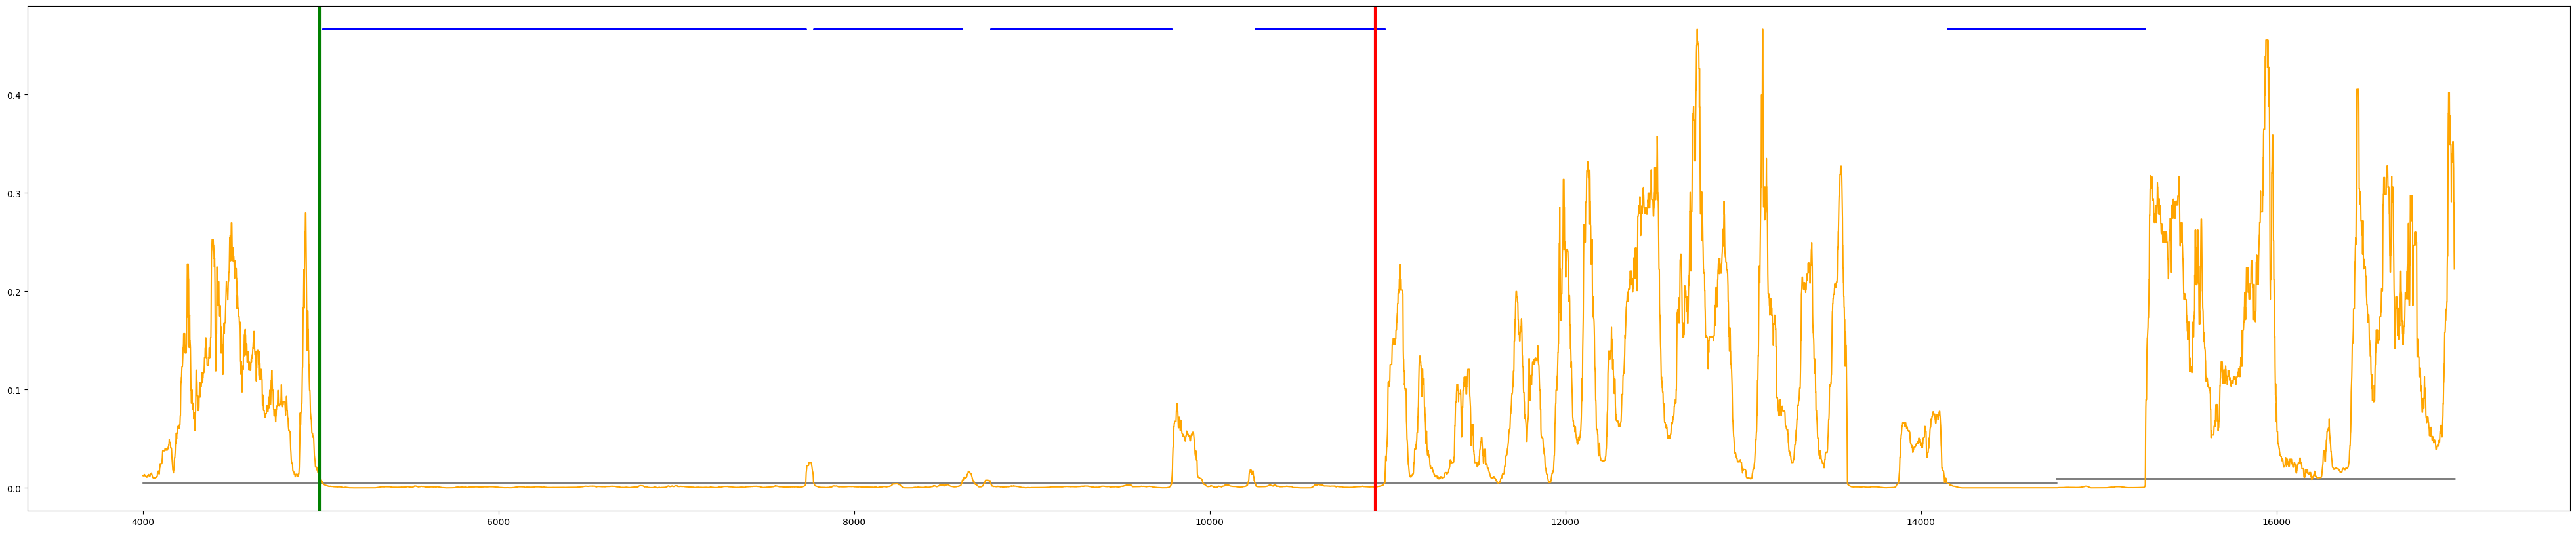

,series_id,step,anglez,enmo,date,time,step4,step5,10th_percentile,step6,sleep_state_block,is_asleep
timestamp,,,,,,,,,,,,
2018-08-14 15:35:00,038441c925bb,60,-1.763978,0.0138,2018-08-14,15:35:00,0.000027,0.000312,0.005242,True,2,True
2018-08-14 15:35:05,038441c925bb,61,-1.763744,0.0137,2018-08-14,15:35:05,0.000234,0.000312,0.005242,True,2,True
2018-08-14 15:35:10,038441c925bb,62,-1.763262,0.0135,2018-08-14,15:35:10,0.000481,0.000351,0.005242,True,2,True
2018-08-14 15:35:15,038441c925bb,63,-1.763494,0.0140,2018-08-14,15:35:15,0.000231,0.000351,0.005242,True,2,True
2018-08-14 15:35:20,038441c925bb,64,-1.763988,0.0132,2018-08-14,15:35:20,0.000494,0.000374,0.005242,True,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-06 04:59:35,038441c925bb,389875,-0.364427,0.0110,2018-09-06,04:59:35,0.009942,0.009266,0.137798,True,956,True
2018-09-06 04:59:40,038441c925bb,389876,-0.367615,0.0110,2018-09-06,04:59:40,0.003188,0.007799,0.137798,True,956,True
2018-09-06 04:59:45,038441c925bb,389877,-0.368676,0.0111,2018-09-06,04:59:45,0.001061,0.006841,0.137798,True,956,True


In [11]:
# @title HDCZA Step 7

sample['sleep_state_block'] = (sample.step6.diff(1) != 0).astype('int').cumsum()

block_sizes = sample[sample.step6].groupby('sleep_state_block').step6.count()
sleep_periods = block_sizes[block_sizes > 360]  # 30 minutes * 60 seconds = 1,800 seconds => 1,800 / 5 = 360 steps (1 step = 5 seconds)
print(f"{sleep_periods.index.to_list()=}")

sample['is_asleep'] = sample.sleep_state_block.isin(sleep_periods.index.to_list())

# clean up predictions for plotting
def get_predictions_for_plot():
    onset_predicions = sample[sample.is_asleep].groupby('sleep_state_block', as_index=False)['step'].min()
    onset_predicions['event'] = 'onset'

    wakeup_predicions = sample[sample.is_asleep].groupby('sleep_state_block', as_index=False)['step'].max()
    wakeup_predicions['event'] = 'wakeup'

    predictions = pd.concat([onset_predicions,wakeup_predicions]).sort_values(by=['step'], ignore_index=True)
    return predictions

# plot
plot_series(data=sample, value_column='step5', labels=train_events, show_quantile=True, predictions=get_predictions_for_plot(),
            snippet_range=(4000,17000), figsize=(50,10)
            )
sample[sample.is_asleep]

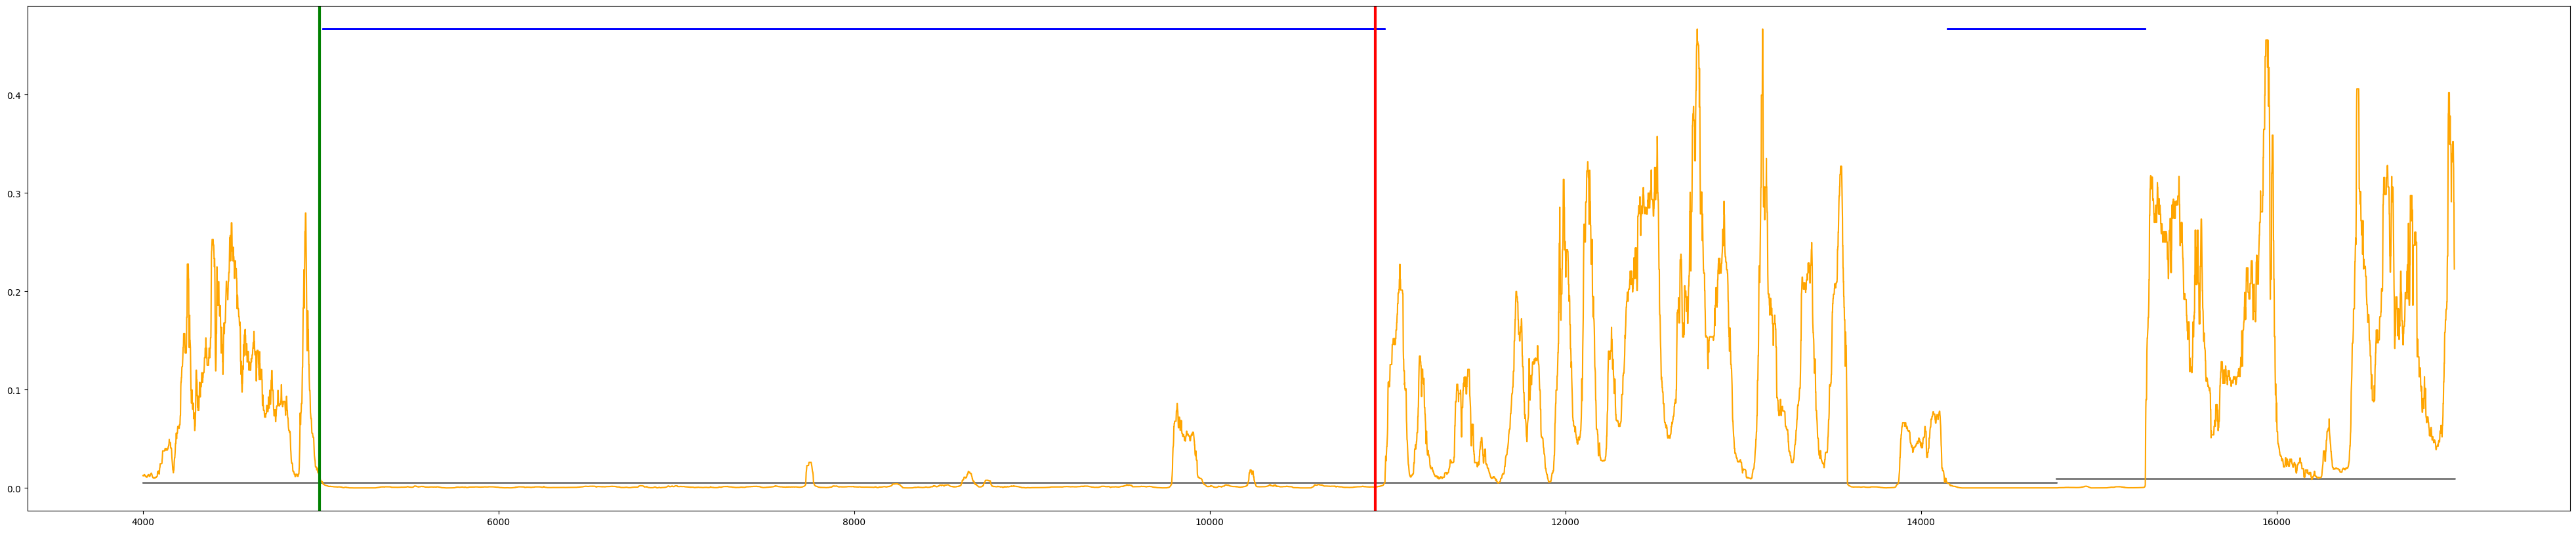

,series_id,step,anglez,enmo,date,time,step4,step5,10th_percentile,step6,sleep_state_block,is_asleep
timestamp,,,,,,,,,,,,
2018-08-14 15:30:00,038441c925bb,0,0.433526,0.0217,2018-08-14,15:30:00,NaN,NaN,0.005242,False,1,True
2018-08-14 15:30:05,038441c925bb,1,0.433529,0.0215,2018-08-14,15:30:05,0.000003,NaN,0.005242,False,1,True
2018-08-14 15:30:10,038441c925bb,2,0.433534,0.0216,2018-08-14,15:30:10,0.000005,NaN,0.005242,False,1,True
2018-08-14 15:30:15,038441c925bb,3,0.433529,0.0213,2018-08-14,15:30:15,0.000005,NaN,0.005242,False,1,True
2018-08-14 15:30:20,038441c925bb,4,0.433529,0.0215,2018-08-14,15:30:20,0.000000,NaN,0.005242,False,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-06 04:59:35,038441c925bb,389875,-0.364427,0.0110,2018-09-06,04:59:35,0.009942,0.009266,0.137798,True,97,True
2018-09-06 04:59:40,038441c925bb,389876,-0.367615,0.0110,2018-09-06,04:59:40,0.003188,0.007799,0.137798,True,97,True
2018-09-06 04:59:45,038441c925bb,389877,-0.368676,0.0111,2018-09-06,04:59:45,0.001061,0.006841,0.137798,True,97,True


In [12]:
# @title HDCZA Step 8
sample['sleep_state_block'] = (sample.is_asleep.diff(1) != 0).astype('int').cumsum()

block_sizes = sample[sample.is_asleep == False].groupby('sleep_state_block').is_asleep.count()
possible_sleep_periods = block_sizes[block_sizes < 720]  # 60 min * 60 seconds = 3,600 seconds => 3,600 seconds / 5 steps = 720 steps (1 step = 5 seconds)

sample.loc[sample.sleep_state_block.isin(possible_sleep_periods.index.to_list()), 'is_asleep'] = True
sample['sleep_state_block'] = (sample.is_asleep.diff(1) != 0).astype('int').cumsum()

plot_series(data=sample, value_column='step5', labels=train_events, show_quantile=True, predictions=get_predictions_for_plot(),
            snippet_range=(4000,17000), figsize=(50,10)
            )
sample[sample.is_asleep]

In [13]:
# @title HDCZA Step 9

timestamps = sample.index.to_list()

windows = []

period_start = timestamps[0]
if timestamps[0] < timestamps[0].replace(hour=12, minute=0, second=0): # before 12:00 noon
    period_end = timestamps[0].replace(hour=12, minute=0, second=0)
else:   # after 12:00 noon
    period_end = period_start.replace(hour=12, minute=0, second=0) + pd.DateOffset(1)

windows.append((period_start, period_end))

while period_end < sample.index.max():
    period_start = period_end
    period_end = period_start + pd.DateOffset(1)
    windows.append((period_start, period_end))

sleep_subset = sample[sample.is_asleep]
longest_sleep_blocks = []
for period_start, period_end in windows:
    sample_subset = sleep_subset[sleep_subset.index.isin(pd.date_range(period_start, period_end, freq='5S'))].groupby('sleep_state_block').step.count()
    if sample_subset.shape[0] > 0:
        longest_sleep_blocks.append({'date': period_start,
                                    'step9': sample_subset.idxmax()})

longest_sleep_blocks

[{'date': Timestamp('2018-08-14 15:30:00'), 'step9': 3},
 {'date': Timestamp('2018-08-15 12:00:00'), 'step9': 7},
 {'date': Timestamp('2018-08-16 12:00:00'), 'step9': 11},
 {'date': Timestamp('2018-08-17 12:00:00'), 'step9': 15},
 {'date': Timestamp('2018-08-18 12:00:00'), 'step9': 17},
 {'date': Timestamp('2018-08-19 12:00:00'), 'step9': 21},
 {'date': Timestamp('2018-08-20 12:00:00'), 'step9': 25},
 {'date': Timestamp('2018-08-21 12:00:00'), 'step9': 33},
 {'date': Timestamp('2018-08-22 12:00:00'), 'step9': 39},
 {'date': Timestamp('2018-08-23 12:00:00'), 'step9': 43},
 {'date': Timestamp('2018-08-24 12:00:00'), 'step9': 45},
 {'date': Timestamp('2018-08-25 12:00:00'), 'step9': 51},
 {'date': Timestamp('2018-08-26 12:00:00'), 'step9': 53},
 {'date': Timestamp('2018-08-27 12:00:00'), 'step9': 55},
 {'date': Timestamp('2018-08-28 12:00:00'), 'step9': 61},
 {'date': Timestamp('2018-08-29 12:00:00'), 'step9': 67},
 {'date': Timestamp('2018-08-30 12:00:00'), 'step9': 71},
 {'date': Timest

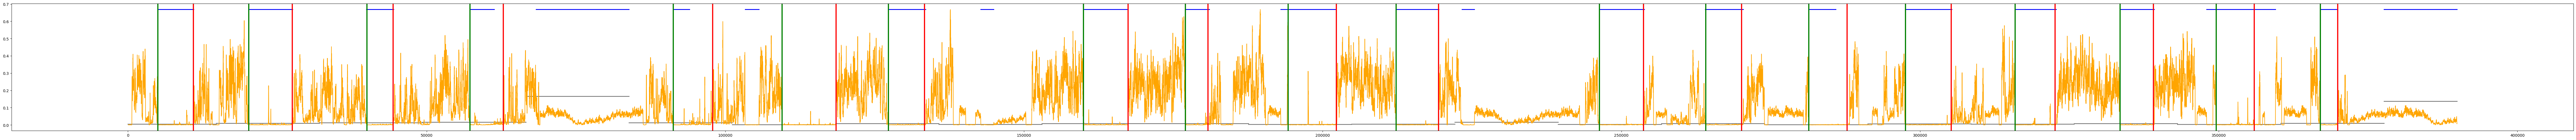

In [14]:
# @title HDCZA Step 10

output = []
for x in longest_sleep_blocks:
    timestamp, block = x['date'], x['step9']

    onset_step = sample.loc[(sample.sleep_state_block == block)].step.min()
    wakeup_step = sample.loc[(sample.sleep_state_block == block)].step.max()

    onset_time = sample[sample.step == onset_step].time.iloc[0].strftime("%H:%M:%S")
    wakeup_time = sample[sample.step == wakeup_step].time.iloc[0].strftime("%H:%M:%S")

    output.append({
        "date": timestamp.date(),
        "onset_step": onset_step,
        "onset_time": onset_time,
        "wakeup_step": wakeup_step,
        "wakeup_time": wakeup_time
    })

    # print(f"{timestamp.date()}:\n\tonset_step={onset_step:,} {onset_time=}\n\twakeup_step={wakeup_step:,} {wakeup_time=}")

submission_output = []
row_id=0
for night in output:
    # Onset
    submission_output.append({
        "row_id": row_id,
        "series_id": id,
        "step": night['onset_step'],
        "event": "onset",
        "score": 1
    })
    row_id +=1

    # Wakeup
    submission_output.append({
        "row_id": row_id,
        "series_id": id,
        "step": night['wakeup_step'],
        "event": "wakeup",
        "score": 1
    })
    row_id +=1
submission = pd.DataFrame.from_dict(submission_output)

plot_series(data=sample, value_column='step5', labels=train_events, show_quantile=True, predictions=submission,
            # snippet_range=(4000,17000), figsize=(50,10)
            )